# Defining the problem

## 1. Description and Background

Canada is a historical land of immigration, and this cultural mesh created a very wide and rich display of different cultures, colors and tastes. At each corner people can find a variety of ethnical cuisine restaurants and shops, some more widely popular than others.  

As many type of cuisines already are famous (italian, american) or many that benefits from a booming interest (asian, japanese) ther are yet continents that are timidly trying to make their food get some keen interest by the general public.  

African food is still not as popular in the public panel and is yet to show it's full potential, bringing unexplored flavours to the city of Toronto.  

Morocco is a historical melting pot that combines influences from plethora of cultures and ethnicities : berbers, arabs, sub saharians, phenicians, jews, romans...  

And this richness can be felt into its very traditional but exquisite cuisine but unfortunately not as well known.  

The goal of this project would be to open a **restaurant chain of moroccan themed food with some african twist**. The simultaneous presence of the stores would have a great impact for advertising moroccan food across the city.

## 2. Description of the data

The data to use would consist in boroughs and neighboroughs of the city of **Toronto** famous for their restaurant and ethnic food concentration. Spots that are well known by foodies and that already holds a customer basis.   

The data should also pinpoint areas with good potential that is free from fierce concurrence.    

The source of data would be a combination of **Wikipedia** boroughs list with **Foursquare API** data of Toronto Venues.  

The classification should be made regarding the ethnical type of food served and be analyzed regarding similar type of foods.

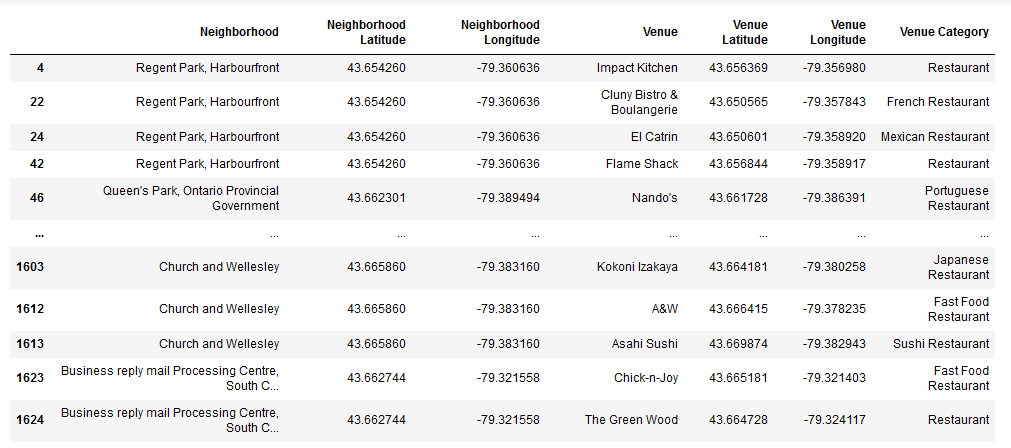

In [1]:
from IPython.display import Image
Image(filename='venues_type.png')

### 2.1 Data Extraction : Toronto Boroughs from Wikipedia

We are going to extract all the **Toronto Boroughs** name and confornt them with their rescpective coordinate data to generate a Dataframe basis

Scraping the data from Wikipedia

In [2]:
import requests

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
response

from bs4 import BeautifulSoup

soup = BeautifulSoup(response.text,'html.parser')
type(soup)

result = soup.find("table",class_="wikitable sortable")

Convert the Data into a Dataframe 

In [3]:
import pandas as pd
import numpy as np

dfs = pd.read_html(str(result))
df= dfs[0]

#cleaning up the useless data
na = df[df['Borough'] == 'Not assigned'].index
df.drop(na,inplace=True)
df.reset_index(drop = True,inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### 2.2 Data Extraction : Combining the Boroughs with their geospatial coordinates

Importing the geospatial coordinates

In [4]:
geo = pd.read_csv('Geospatial_Coordinates.csv')

In [5]:
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging the 2 Dataframes

In [6]:
merged = pd.merge(df,geo,on=['Postal Code'])
merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Reducing down to Boroughs containing the word 'Toronto'

In [7]:
toronto_df=merged[merged['Borough'].str.contains("Toronto")]
toronto_df.columns=["Postal Code", "Borough", "Neighborhood","Latitude","Longitude"]
toronto_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


### 2.3 Data Extraction : Coupling the Tronto boroughs with Foursquare API data

In [8]:
CLIENT_ID = 'PGSXXB0HS0W0KTJNP4TE1XTTPFW431RUVC3WB0YKEA02TUUD' # your Foursquare ID
CLIENT_SECRET = 'XPJP2IQHKPRSAZ1RPZXRYVLHGSDREGJIIKO4OJXRTGBJEYUS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: PGSXXB0HS0W0KTJNP4TE1XTTPFW431RUVC3WB0YKEA02TUUD
CLIENT_SECRET:XPJP2IQHKPRSAZ1RPZXRYVLHGSDREGJIIKO4OJXRTGBJEYUS


In [9]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Listing Toronto Venues**

In [10]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],latitudes=toronto_df['Latitude'],longitudes=toronto_df['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [11]:
print("Toronto Venues Shape : ",toronto_venues.shape)
toronto_venues.head(10)

Toronto Venues Shape :  (1627, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
5,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
6,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
7,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
8,"Regent Park, Harbourfront",43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
9,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


## 3. Methodology

### 3.1 Isolating the different restaurant types

**Identifying the different ype of venues and isolating the restaurants**

In [12]:
venue_categories = toronto_venues.groupby('Venue Category').count()
venue_categories

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Afghan Restaurant,1,1,1,1,1,1
Airport,1,1,1,1,1,1
Airport Food Court,1,1,1,1,1,1
Airport Gate,1,1,1,1,1,1
Airport Lounge,2,2,2,2,2,2
...,...,...,...,...,...,...
Vietnamese Restaurant,7,7,7,7,7,7
Wine Bar,10,10,10,10,10,10
Wine Shop,1,1,1,1,1,1


In [13]:
restaurant_type = []
for i in venue_categories.index:
    if 'Restaurant' in i:
        print(i)
        restaurant_type.append(i)
    

Afghan Restaurant
American Restaurant
Asian Restaurant
Belgian Restaurant
Brazilian Restaurant
Cajun / Creole Restaurant
Caribbean Restaurant
Chinese Restaurant
Colombian Restaurant
Comfort Food Restaurant
Cuban Restaurant
Doner Restaurant
Dumpling Restaurant
Eastern European Restaurant
Ethiopian Restaurant
Falafel Restaurant
Fast Food Restaurant
Filipino Restaurant
French Restaurant
German Restaurant
Gluten-free Restaurant
Greek Restaurant
Indian Restaurant
Italian Restaurant
Japanese Restaurant
Korean Restaurant
Latin American Restaurant
Mediterranean Restaurant
Mexican Restaurant
Middle Eastern Restaurant
Modern European Restaurant
Molecular Gastronomy Restaurant
Moroccan Restaurant
New American Restaurant
Persian Restaurant
Portuguese Restaurant
Ramen Restaurant
Restaurant
Seafood Restaurant
Sushi Restaurant
Taiwanese Restaurant
Thai Restaurant
Theme Restaurant
Vegetarian / Vegan Restaurant
Vietnamese Restaurant


**Isolating the restaurants**

In [14]:
restaurant_type_list = []
for i, row_i in toronto_venues.iterrows():
    print(row_i['Venue Category'])
    if row_i['Venue Category'] in restaurant_type:
        restaurant_type_list.append(row_i)


Bakery
Coffee Shop
Distribution Center
Spa
Restaurant
Park
Historic Site
Breakfast Spot
Gym / Fitness Center
Pub
Farmers Market
Coffee Shop
Chocolate Shop
Coffee Shop
Dessert Shop
Performing Arts Venue
Breakfast Spot
Bakery
Coffee Shop
Coffee Shop
Park
Theater
French Restaurant
Café
Mexican Restaurant
Yoga Studio
Park
Café
Coffee Shop
Theater
Event Space
Pub
Shoe Store
Pub
Ice Cream Shop
Bakery
Café
Cosmetics Shop
Electronics Store
Bank
Coffee Shop
Beer Store
Wine Shop
Coffee Shop
Antique Shop
Park
Portuguese Restaurant
Italian Restaurant
Coffee Shop
Distribution Center
Coffee Shop
Creperie
Beer Bar
Sushi Restaurant
Persian Restaurant
Yoga Studio
Arts & Crafts Store
Coffee Shop
Mexican Restaurant
Hobby Shop
Japanese Restaurant
Diner
Theater
Fried Chicken Joint
Coffee Shop
Coffee Shop
Smoothie Shop
Bank
Sandwich Place
Coffee Shop
Café
Coffee Shop
College Auditorium
Gym
Coffee Shop
Bar
Coffee Shop
College Cafeteria
Vegetarian / Vegan Restaurant
Music Venue
General Entertainment
Clothing 

In [15]:
restaurant_type_list

[Neighborhood              Regent Park, Harbourfront
 Neighborhood Latitude                       43.6543
 Neighborhood Longitude                     -79.3606
 Venue                                Impact Kitchen
 Venue Latitude                              43.6564
 Venue Longitude                             -79.357
 Venue Category                           Restaurant
 Name: 4, dtype: object,
 Neighborhood               Regent Park, Harbourfront
 Neighborhood Latitude                        43.6543
 Neighborhood Longitude                      -79.3606
 Venue                     Cluny Bistro & Boulangerie
 Venue Latitude                               43.6506
 Venue Longitude                             -79.3578
 Venue Category                     French Restaurant
 Name: 22, dtype: object,
 Neighborhood              Regent Park, Harbourfront
 Neighborhood Latitude                       43.6543
 Neighborhood Longitude                     -79.3606
 Venue                                   

**regroup the data into a pandas dataframe**

In [16]:
toronto_resto = pd.DataFrame(restaurant_type_list)
toronto_resto.reset_index(drop=True,inplace=True)
print("Toronto Resto shape : ",toronto_resto.shape)
toronto_resto.head()

Toronto Resto shape :  (379, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
1,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Nando's,43.661728,-79.386391,Portuguese Restaurant
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant


### 3.2 Displaying the different restaurants on a map

**Importing the necessary libraries**

In [18]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

**Creating the map**

In [19]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="xxx")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [25]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, venue_cat,neighborhood in zip(toronto_resto['Venue Latitude'], toronto_resto['Venue Longitude'], toronto_resto['Venue Category'], toronto_resto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, venue_cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Sorting Restaurants by frequency**

In [32]:
toronto_resto['Venue Category'].value_counts()

Restaurant                         53
Italian Restaurant                 38
Japanese Restaurant                33
Sushi Restaurant                   25
American Restaurant                23
Seafood Restaurant                 22
Vegetarian / Vegan Restaurant      17
Thai Restaurant                    16
Asian Restaurant                   12
Greek Restaurant                   12
Mexican Restaurant                 12
Fast Food Restaurant               10
French Restaurant                  10
New American Restaurant             8
Middle Eastern Restaurant           7
Indian Restaurant                   7
Vietnamese Restaurant               7
Chinese Restaurant                  6
Comfort Food Restaurant             6
Caribbean Restaurant                5
Mediterranean Restaurant            4
Gluten-free Restaurant              4
Latin American Restaurant           4
Ramen Restaurant                    4
Eastern European Restaurant         3
Modern European Restaurant          3
Belgian Rest

**We can notice that there are only 2 moroccan restaurants in all the areas scouted**

In [36]:
toronto_resto[toronto_resto['Venue Category'] == 'Moroccan Restaurant']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
49,St. James Town,43.651494,-79.375418,Berber SOCIAL,43.648114,-79.374046,Moroccan Restaurant
50,St. James Town,43.651494,-79.375418,The Sultan's Tent and Cafe Moroc,43.647928,-79.374341,Moroccan Restaurant


**We can notice that there are only 2 moroccan restaurants in all the areas scouted, both located in the neighborhood of St. James Town**